<a href="https://colab.research.google.com/github/alameenp/Coursera_Capstone/blob/coursera/Battle_of_neighbourhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Battle of Neighborhoods**

# Importing libraries

In [ ]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup
import csv

!pip install geocoder
import geocoder # to get longitude and latitude

#!conda install -c conda-forge folium=0.5.0 --yes
import numpy as np
from pandas.io.json import json_normalize # Tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Import k-means from clustering stage
from sklearn.cluster import KMeans
!pip install folium
import folium # map rendering library

/bin/bash: conda: command not found
     |████████████████████████████████| 102kB 4.4MB/s 


## Store the geographical data of Neighborhoods of Mumbai in a pandas dataframe

In [ ]:
path='https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'
table=pd.read_html(path,header=0)
df=table[0]
df.head(10)

,Area,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270
5,Marol,"Andheri,Western Suburbs",19.119219,72.882743
6,Sahar,"Andheri,Western Suburbs",19.098889,72.867222
7,Seven Bungalows,"Andheri,Western Suburbs",19.129052,72.817018
8,Versova,"Andheri,Western Suburbs",19.120000,72.820000
9,Mira Road,"Mira-Bhayandar,Western Suburbs",19.284167,72.871111


Renaming the column title 'Area' to 'Neighborhood'

In [ ]:
df.rename(columns={'Area':'Neighborhood'}, inplace=True)

In [ ]:
df.head()

,Neighborhood,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270


## Setting up Foursquare API credentials

In [1]:
CLIENT_ID = 'your client id' 
CLIENT_SECRET = 'your client secret' 
VERSION = '20201203'

Get the latitude and longitude of Mumbai city

In [ ]:
from geopy.geocoders import Nominatim

address = 'Mumbai, Maharashtra, India'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai are 18.9387711, 72.8353355.


# Plot the map of Mumbai using latitude and longitude values

In [ ]:
mum_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mum_map)  
    
mum_map

## Defining a function which extracts categories from Foursquare venues

In [ ]:
# Gets the name of the category

def get_category_type(row):
    categories_list = row['Category']  
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
explore_df_list = []

for i, nhood_name in enumerate(df['Neighborhood']):  
    
    try :
        #Get neighbourhood data
        nhood_name = df.loc[i, 'Neighborhood']
        nhood_lat = df.loc[i, 'Latitude']
        nhood_lng = df.loc[i, 'Longitude']

        radius = 1000 
        LIMIT = 30 

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={} \
        &client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, nhood_lat, nhood_lng, VERSION, radius, LIMIT)

        results = json.loads(requests.get(url).text)
        results = results['response']['groups'][0]['items']

        nearby = json_normalize(results) # Flatten JSON

        # Filter the columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby = nearby.loc[:, filtered_columns]

        # Rename the columns
        columns = ['Name', 'Category', 'Latitude', 'Longitude']
        nearby.columns = columns

        # Get the categories
        nearby['Category'] = nearby.apply(get_category_type, axis=1)    

        # Get the required data
        for i, name in enumerate(nearby['Name']):
            s_list = nearby.loc[i, :].values.tolist()  # Converts the numpy array to a python list
            f_list = [nhood_name, nhood_lat, nhood_lng] + s_list
            explore_df_list.append(f_list)
    
    except Exception as e:
        pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


# Create a dataframe for performing clustering.

In [ ]:
explore_mum = pd.DataFrame([item for item in explore_df_list])
explore_mum.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Name', 'Venue Category', 'Venue Latitude', 'Venue Longitude']
explore_mum.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,Amboli,19.1293,72.8434,Shawarma Factory,Falafel Restaurant,19.124591,72.840398
1,Amboli,19.1293,72.8434,Jaffer Bhai's Delhi Darbar,Mughlai Restaurant,19.137714,72.845909
2,Amboli,19.1293,72.8434,Cafe Arfa,Indian Restaurant,19.128930,72.847140
3,Amboli,19.1293,72.8434,"5 Spice , Bandra",Chinese Restaurant,19.130421,72.847206
4,Amboli,19.1293,72.8434,Pizza Express,Pizza Place,19.131893,72.834668
5,Amboli,19.1293,72.8434,Courtyard Restaurant & Bar,Asian Restaurant,19.131692,72.837269
6,Amboli,19.1293,72.8434,Persia Darbar,Indian Restaurant,19.136952,72.846822
7,Amboli,19.1293,72.8434,Garden Court,Indian Restaurant,19.127188,72.837478
8,Amboli,19.1293,72.8434,Road House Bluez,Pub,19.127251,72.836045
9,Amboli,19.1293,72.8434,Shetty's Corner,Chinese Restaurant,19.124845,72.837858


# Perform one-hot encoding to analyze neighbourhoods of Mumbai.

In [ ]:
mum_1hot = pd.get_dummies(explore_mum[['Venue Category']], prefix="", prefix_sep="")


# Add neighbourhood column back to dataframe
mum_1hot['Neighborhood'] = explore_mum['Neighborhood'] 


# Move neighbourhood column to the first column
col_name ='Neighborhood'
first_col = mum_1hot.pop(col_name)
mum_1hot.insert(0, col_name, first_col)



mum_1hot.head(10)

,Neighborhood,ATM,Afghan Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Station,Bus Stop,Café,Camera Store,Chaat Place,Cheese Shop,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Auditorium,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,General Entertainment,German Restaurant,Gift Shop,Goan Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,History Museum,Hockey Arena,Hookah Bar,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Light Rail Station,Lighthouse,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Mughlai Restaurant,Multiplex,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant,Other Great Outdoors,Outdoors & Recreation,Park,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Punjabi Restaurant,Racetrack,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Sushi Restaurant,Tea Room,Tennis Court,Theater,Theme Park,Toy / Game Store,Track,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Women's Store,Zoo
0,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
mum_grouped = mum_1hot.groupby('Neighborhood').mean().reset_index()
mum_grouped.head(10)

,Neighborhood,ATM,Afghan Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Station,Bus Stop,Café,Camera Store,Chaat Place,Cheese Shop,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Auditorium,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,General Entertainment,German Restaurant,Gift Shop,Goan Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,History Museum,Hockey Arena,Hookah Bar,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Light Rail Station,Lighthouse,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Mughlai Restaurant,Multiplex,Music Store,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant,Other Great Outdoors,Outdoors & Recreation,Park,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Punjabi Restaurant,Racetrack,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Sushi Restaurant,Tea Room,Tennis Court,Theater,Theme Park,Toy / Game Store,Track,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Women's Store,Zoo
0,Aarey Milk Colony,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.125000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.125,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.125,0.0,0.0,0.0,0.000000,0.125000,0.0,0.000000,0.000000,0.0,0.0,0.125000,0.00,0.0,0.000000,0.0,0.125000,0.0,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.125,0.125000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000
1,Agripada,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.043478,0.000000,0.0,0.000000,0.0,0.130435,0.0,0.043478,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.043478,0.000000,0.086957,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.043478,0.0,0.0

In [ ]:
def top_common_venues(row, top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:top_venues]

## Create a new dataframe to get the top 10 venues

In [ ]:
top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mum_grouped['Neighborhood']

for ind in np.arange(mum_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = top_common_venues(mum_grouped.iloc[ind, :], top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aarey Milk Colony,Golf Course,Café,Restaurant,Resort,Indian Restaurant,Hotel,Farm,Gym / Fitness Center,Cosmetics Shop,Comedy Club
1,Agripada,Indian Restaurant,Bakery,Gym,Coffee Shop,Restaurant,Asian Restaurant,Bar,Club House,Cupcake Shop,Fast Food Restaurant
2,Altamount Road,Bakery,Chinese Restaurant,Pizza Place,History Museum,Fast Food Restaurant,Snack Place,Department Store,Deli / Bodega,Bar,Hotel
3,Amboli,Indian Restaurant,Bar,Pizza Place,Chinese Restaurant,Pub,Coffee Shop,Asian Restaurant,Falafel Restaurant,Bowling Alley,Snack Place
4,Amrut Nagar,Lounge,Diner,Clothing Store,Indian Restaurant,Fast Food Restaurant,Café,Bowling Alley,Brewery,Electronics Store,Punjabi Restaurant


# Apply K-means clustering on the dataframe.

In [ ]:
mum_grouped_clustering = mum_grouped.drop('Neighborhood', 1)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [ ]:
max_range = 15 #Max range 15 (number of clusters)

from sklearn.metrics import silhouette_samples, silhouette_score


indices = []
scores = []

for mum_clusters in range(2, max_range) :
    
    # Run k-means clustering
    mum_gc = mum_grouped_clustering
    kmeans = KMeans(n_clusters = mum_clusters, init = 'k-means++', random_state = 0).fit_predict(mum_gc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(mum_gc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(mum_clusters)
    scores.append(score)

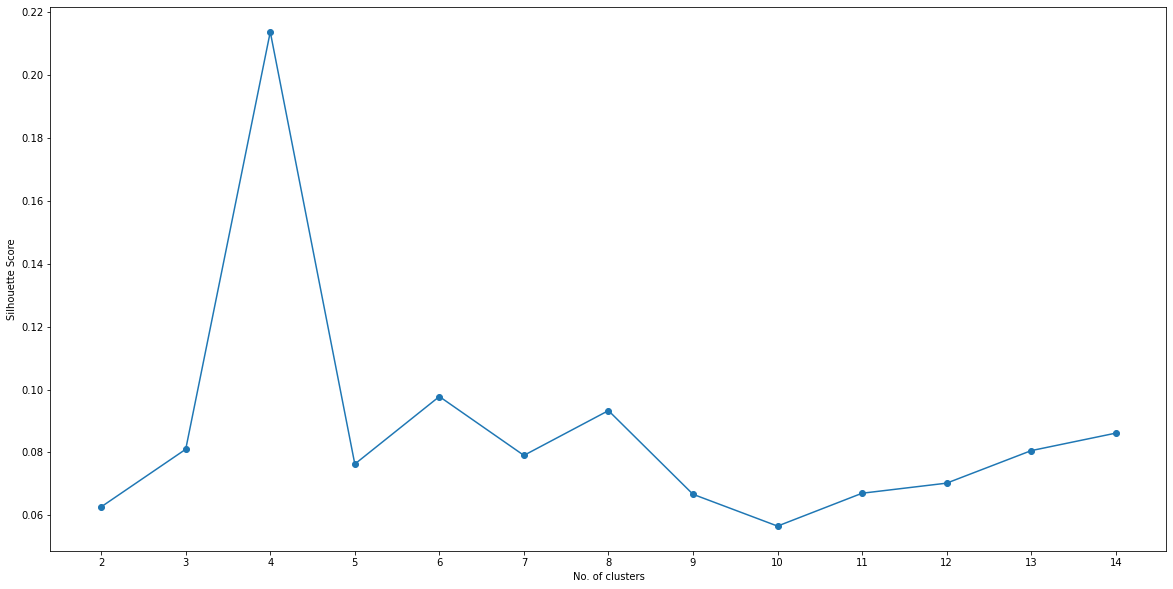

In [ ]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")


From the graph the optimum number of clusters is found out to be 10 using the Elbow Method


In [ ]:
opt_value = 10

In [ ]:

mum_clusters = opt_value

# Run k-means clustering
mum_gc = mum_grouped_clustering
kmeans = KMeans(n_clusters = mum_clusters, init = 'k-means++', random_state = 0).fit(mum_gc)

In [ ]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


Create a final version of dataframe containing all the necessary data.

In [ ]:
mum_final = df
mum_final = mum_final.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
mum_final.dropna(inplace = True)
mum_final['Cluster Labels'] = mum_final['Cluster Labels'].astype(int)
mum_final.head()

,Neighborhood,Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400,3,Indian Restaurant,Bar,Pizza Place,Chinese Restaurant,Pub,Coffee Shop,Asian Restaurant,Falafel Restaurant,Bowling Alley,Snack Place
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,3,Indian Restaurant,Seafood Restaurant,Hotel,Café,Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Pizza Place,Asian Restaurant
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373,1,Bar,Pub,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Pizza Place,Juice Bar,Liquor Store,Falafel Restaurant,Donut Shop,Japanese Restaurant
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210,1,Pub,Bar,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Residential Building (Apartment / Condo),Fish Market
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270,1,Bar,Lounge,Multiplex,Juice Bar,Italian Restaurant,Pizza Place,Pub,Café,Liquor Store,Residential Building (Apartment / Condo)


In [ ]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Setup color scheme for different clusters
x = np.arange(mum_clusters)
ys = [i + x + (i*x)**2 for i in range(mum_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(mum_final['Latitude'], mum_final['Longitude'], mum_final['Neighborhood'], 
                                  mum_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster + 1) + ')', parse_html=True)
    map_clusters.add_child(
        folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7))
       
map_clusters


Now lets have a look at all 10 clusters.¶


In [ ]:
val = 1
mum_final.loc[mum_final['Cluster Labels'] == (val - 1), mum_final.columns[[0] + np.arange(4, mum_final.shape[1]).tolist()]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Bhayandar,0,Fast Food Restaurant,Coffee Shop,Indian Restaurant,Mexican Restaurant,Pizza Place,Garden,Light Rail Station,Multiplex,Food Truck,Restaurant
12,Bandstand Promenade,0,Coffee Shop,Scenic Lookout,Gym,Beach,Food Truck,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Fast Food Restaurant
15,I.C. Colony,0,Chinese Restaurant,Indian Restaurant,Bar,Fast Food Restaurant,Dessert Shop,Department Store,Ice Cream Shop,Italian Restaurant,Juice Bar,Lounge
19,Bangur Nagar,0,Coffee Shop,Clothing Store,Multiplex,Smoke Shop,Indian Restaurant,Fast Food Restaurant,Pub,Deli / Bodega,Ice Cream Shop,Bookstore
23,Poisar,0,Bakery,Fast Food Restaurant,Food Truck,Chinese Restaurant,Coffee Shop,Bar,Bank,Food,Pool,Juice Bar
24,Mahavir Nagar,0,Fast Food Restaurant,Indian Restaurant,Ice Cream Shop,Coffee Shop,Gym / Fitness Center,Pizza Place,Park,Dessert Shop,Electronics Store,Bike Rental / Bike Share
28,Dindoshi,0,Fast Food Restaurant,Bar,Multiplex,Vegetarian / Vegan Restaurant,Coffee Shop,Donut Shop,Gym,Bookstore,Brewery,Sandwich Place
30,Kalina,0,Gym,Steakhouse,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Clothing Store,Convenience Store,Food Truck,Boutique,Jewelry Store
33,Virar,0,Fast Food Restaurant,Indian Chinese Restaurant,Pizza Place,Theme Park,Department Store,Indian Restaurant,Factory,Event Space,Electronics Store,Dumpling Restaurant
46,Vidyavihar,0,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Indian Restaurant,Bar,Dessert Shop,Movie Theater,Restaurant,Sandwich Place,Cricket Ground


In [ ]:
val = 2
mum_final.loc[mum_final['Cluster Labels'] == (val - 1), mum_final.columns[[0] + np.arange(4, mum_final.shape[1]).tolist()]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,D.N. Nagar,1,Bar,Pub,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Pizza Place,Juice Bar,Liquor Store,Falafel Restaurant,Donut Shop,Japanese Restaurant
3,Four Bungalows,1,Pub,Bar,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Residential Building (Apartment / Condo),Fish Market
4,Lokhandwala,1,Bar,Lounge,Multiplex,Juice Bar,Italian Restaurant,Pizza Place,Pub,Café,Liquor Store,Residential Building (Apartment / Condo)
7,Seven Bungalows,1,Café,Ice Cream Shop,Pub,Seafood Restaurant,Indian Restaurant,Pizza Place,Recreation Center,Diner,Donut Shop,Bistro
9,Mira Road,1,Pizza Place,Multiplex,Gym / Fitness Center,Indian Restaurant,Ice Cream Shop,Café,Bakery,Bank,Sandwich Place,Sculpture Garden
17,Dahisa,1,Juice Bar,Chinese Restaurant,Café,Indian Restaurant,Bar,Bakery,Pizza Place,Department Store,Dessert Shop,Middle Eastern Restaurant
22,Charkop,1,Gym,Chinese Restaurant,Fast Food Restaurant,Ice Cream Shop,Indian Restaurant,Pizza Place,Playground,Café,Food Truck,Smoke Shop
27,Khar Danda,1,Bar,Seafood Restaurant,Café,Dessert Shop,Gym / Fitness Center,Lounge,Asian Restaurant,Ice Cream Shop,Modern European Restaurant,Pub
29,Sunder Nagar,1,Multiplex,Shopping Mall,Indian Restaurant,Fast Food Restaurant,Café,Coffee Shop,Bookstore,Pub,Pizza Place,Clothing Store
36,Bhandup,1,Train Station,Indian Restaurant,Shopping Mall,Gym,Sports Bar,Chinese Restaurant,Gift Shop,Pizza Place,Café,Bookstore


In [ ]:
val = 3
mum_final.loc[mum_final['Cluster Labels'] == (val - 1), mum_final.columns[[0] + np.arange(4, mum_final.shape[1]).tolist()]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Nalasopara,2,Bar,Bus Station,Zoo,Department Store,Falafel Restaurant,Factory,Event Space,Electronics Store,Dumpling Restaurant,Donut Shop


In [ ]:
val = 4
mum_final.loc[mum_final['Cluster Labels'] == (val - 1), mum_final.columns[[0] + np.arange(4, mum_final.shape[1]).tolist()]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,3,Indian Restaurant,Bar,Pizza Place,Chinese Restaurant,Pub,Coffee Shop,Asian Restaurant,Falafel Restaurant,Bowling Alley,Snack Place
1,"Chakala, Andheri",3,Indian Restaurant,Seafood Restaurant,Hotel,Café,Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Pizza Place,Asian Restaurant
6,Sahar,3,Coffee Shop,Indian Restaurant,Hotel,Lounge,Fast Food Restaurant,Hotel Bar,Italian Restaurant,Café,Bar,Beer Garden
8,Versova,3,Indian Restaurant,Café,Gym,Pub,Multiplex,Clothing Store,Beach,Bistro,Pizza Place,Park
13,Kherwadi,3,Bakery,Indian Restaurant,Gourmet Shop,Café,Deli / Bodega,Snack Place,Chinese Restaurant,BBQ Joint,Park,Pizza Place
14,Pali Hill,3,Bakery,Seafood Restaurant,Indian Restaurant,Scenic Lookout,Fast Food Restaurant,Cupcake Shop,Deli / Bodega,Bagel Shop,Salon / Barbershop,Lounge
18,Aarey Milk Colony,3,Golf Course,Café,Restaurant,Resort,Indian Restaurant,Hotel,Farm,Gym / Fitness Center,Cosmetics Shop,Comedy Club
21,Juhu,3,Bar,Indian Restaurant,Hotel,Seafood Restaurant,Beach,Spa,Café,Bakery,Breakfast Spot,Donut Shop
25,Thakur village,3,Indian Restaurant,Lounge,Pizza Place,Ice Cream Shop,Fast Food Restaurant,Café,Restaurant,Gym,Sports Bar,Indie Movie Theater
26,Pali Naka,3,Indian Restaurant,Seafood Restaurant,Dessert Shop,Café,Deli / Bodega,Arcade,Bakery,Salad Place,French Restaurant,Farmers Market


In [ ]:
val = 5
mum_final.loc[mum_final['Cluster Labels'] == (val - 1), mum_final.columns[[0] + np.arange(4, mum_final.shape[1]).tolist()]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Marol,4,Indian Restaurant,Hotel,Fast Food Restaurant,Ice Cream Shop,Convenience Store,Chinese Restaurant,Dance Studio,Diner,Restaurant,Lounge
20,Jogeshwari West,4,Indian Restaurant,Pizza Place,Fast Food Restaurant,Camera Store,Shopping Mall,Hotel,Restaurant,Department Store,Bakery,Sandwich Place
38,Asalfa,4,Indian Restaurant,Coffee Shop,Factory,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Light Rail Station,Electronics Store,Donut Shop,Bakery,Zoo
39,Pant Nagar,4,Indian Restaurant,Fast Food Restaurant,Coffee Shop,Pizza Place,Dessert Shop,Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant,Multiplex,Gym / Fitness Center
42,Nahur,4,Indian Restaurant,Restaurant,Clothing Store,Coffee Shop,Train Station,Café,Pub,Bar,Ice Cream Shop,Department Store
45,Indian Institute of Technology Bombay campus,4,Indian Restaurant,Coffee Shop,Bakery,Concert Hall,Event Space,Dance Studio,Café,Asian Restaurant,Food Court,Falafel Restaurant
48,Chembur,4,Indian Restaurant,Pizza Place,Fast Food Restaurant,Snack Place,Café,Gym,Smoke Shop,Punjabi Restaurant,Pool,Coffee Shop
49,Deonar,4,Indian Restaurant,Bar,Fast Food Restaurant,Gym,General Entertainment,Food Court,Snack Place,Smoke Shop,Coffee Shop,Golf Course
52,Agripada,4,Indian Restaurant,Bakery,Gym,Coffee Shop,Restaurant,Asian Restaurant,Bar,Club House,Cupcake Shop,Fast Food Restaurant
54,Bhuleshwar,4,Indian Restaurant,Café,Fast Food Restaurant,Bakery,BBQ Joint,Restaurant,Dessert Shop,Middle Eastern Restaurant,Ice Cream Shop,Bar


In [ ]:
val = 6
mum_final.loc[mum_final['Cluster Labels'] == (val - 1), mum_final.columns[[0] + np.arange(4, mum_final.shape[1]).tolist()]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Naigaon,5,ATM,Chinese Restaurant,Train Station,Cocktail Bar,Platform,College Auditorium,Factory,Event Space,Electronics Store,Dumpling Restaurant


In [ ]:
val = 7
mum_final.loc[mum_final['Cluster Labels'] == (val - 1), mum_final.columns[[0] + np.arange(4, mum_final.shape[1]).tolist()]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
81,Navy Nagar,6,Golf Course,General Entertainment,Beach,Asian Restaurant,Zoo,Department Store,Falafel Restaurant,Factory,Event Space,Electronics Store


In [ ]:
val = 8
mum_final.loc[mum_final['Cluster Labels'] == (val - 1), mum_final.columns[[0] + np.arange(4, mum_final.shape[1]).tolist()]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Mankhurd,7,Gym,Train Station,Bus Station,Diner,Sports Bar,Coffee Shop,German Restaurant,Factory,Electronics Store,Dumpling Restaurant


In [ ]:
val = 9
mum_final.loc[mum_final['Cluster Labels'] == (val - 1), mum_final.columns[[0] + np.arange(4, mum_final.shape[1]).tolist()]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Uttan,8,Beach,Indian Restaurant,Playground,Bus Station,Resort,Zoo,Factory,Event Space,Electronics Store,Dumpling Restaurant
16,Gorai,8,Seafood Restaurant,Beach,Food,Indian Restaurant,Farm,Falafel Restaurant,Factory,Event Space,Electronics Store,Dumpling Restaurant
64,Dongri,8,Beach,Indian Restaurant,Playground,Bus Station,Resort,Zoo,Factory,Event Space,Electronics Store,Dumpling Restaurant


In [ ]:
val = 10
mum_final.loc[mum_final['Cluster Labels'] == (val - 1), mum_final.columns[[0] + np.arange(4, mum_final.shape[1]).tolist()]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,Mahalaxmi,9,Arcade,Zoo,Department Store,Farm,Falafel Restaurant,Factory,Event Space,Electronics Store,Dumpling Restaurant,Donut Shop


###**It is observed that most of the service sector businesses are concentrated in the cluster labelled 5, therefore the neighbourhoods in cluster 5 will be good locations for launching a new restaurant**